<a href="https://colab.research.google.com/github/Michell203/DingLab/blob/main/DLabCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy

In [96]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy
import matplotlib.pyplot as plt

import math
from random import randrange
import itertools

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
# from scipy.special import softmax

# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html - Scanpy preprocess
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html - Scanpy h5ad
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_10x_h5.html - Scanpy 10x h5
# https://scanpy.readthedocs.io/en/stable/index.html - Scanpy webpage

# https://www.partek.com/webinar/understanding-data-formats-and-preprocessing/
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# Preprocess
Get a sense of the data (GSM4504959_E12.5_filtered_gene_bc_matrices.h5)

Cell count: 9792,
Gene count: 27998

In [ ]:
t1 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504959_E12.5_filtered_gene_bc_matrices.h5")
t1.var_names_make_unique()
print(t1.X)

In [ ]:
array = t1.X.toarray()
number = 0
for i in range(9791):
  number += array[i,27997]
mean_of_gene1 = number/9791
print(mean_of_gene1)

0.0013277499744663466


In [ ]:
t1.X

In [ ]:
sc.pp.normalize_total(t1, target_sum=1e4)

In [ ]:
pseudobulk_h5_file_1 = t1.X.mean(axis=0)
print(pseudobulk_h5_file_1)

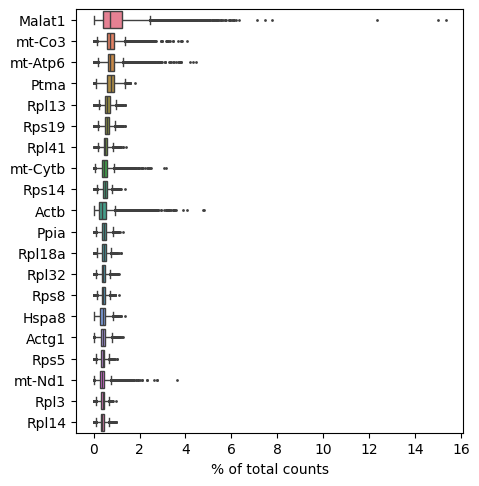

None


In [ ]:
print(sc.pl.highest_expr_genes(t1, n_top=20, ))

In [ ]:
sc.pp.normalize_total(t1, target_sum=1e4)
# sc.pp.log1p(t1)

In [ ]:
pseudobulk_t1 = t1.X.mean(axis=0)
print(pseudobulk_t1)

In [ ]:
# Generate new information about counts
t1.var_names_make_unique()
sc.pp.calculate_qc_metrics(t1, log1p=False, inplace=True)

frame1_obs = pd.DataFrame(t1.obs)
frame1_obs.drop(['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'], axis=1)

frame1_vars = pd.DataFrame(t1.var)

In [ ]:
t1.layers["t1.X"] = t1.X
t1.to_df(layer="t1.X")

# Create Pseudobulk

In [ ]:
t0 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504959_E12.5_filtered_gene_bc_matrices.h5")
t1 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504960_E15.5_filtered_gene_bc_matrices.h5")
t2 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504961_E17.5_filtered_gene_bc_matrices.h5")
t3 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504962_P3_filtered_gene_bc_matrices.h5")
t4 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504963_P7_filtered_gene_bc_matrices.h5")
t5 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504964_P15_filtered_gene_bc_matrices.h5")
t6 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504965_P42_filtered_gene_bc_matrices.h5")

h5_files = [t0, t1, t2, t3, t4, t5, t6]
pseudo_bulks = []

In [4]:
t0.var_names
max_value = t0.X.max()
print(max_value)

4894.0


In [5]:
def pseudo_bulk(h5_file): # Creates pseudobulk of h5 file
  sc.pp.normalize_total(h5_file, target_sum=1e4)
  pseudobulk_h5_file = h5_file.X.mean(axis=0)

  values = []
  for i in range(pseudobulk_h5_file.shape[1]):
    values.append(pseudobulk_h5_file[0,i])

  return np.array(values)

In [6]:
def create_pseudo_bulk(h5_files): # Generates pseudobulk from all time-stamps
  pseudo_bulks = []
  for h5_file in h5_files:
    pseudo_h5 = pseudo_bulk(h5_file)
    pseudo_bulks.append(pseudo_h5)

  return np.array(pseudo_bulks)

In [ ]:
obs_names = {} # For .obs of bulk AnnData object
for i in range(len(h5_files)): # 7
  obs_names[i] = "TimeStamp" + str(i)
obs_frame = pd.DataFrame(list(obs_names.items()), columns=['Index', 'TimeStamp'])
print(obs_frame)

In [ ]:
bulks = create_pseudo_bulk(h5_files)
bulks_adata = ad.AnnData(bulks, obs=obs_frame, var=t0.var)

In [ ]:
print(bulks_adata.X)
print(bulks_adata.obs)
print(bulks_adata.var)

In [10]:
bulks_adata.obs['files'] = ['GSM4504959_E12.5_filtered_gene_bc_matrices.h5', 'GSM4504960_E15.5_filtered_gene_bc_matrices.h5',
                            'GSM4504961_E17.5_filtered_gene_bc_matrices.h5', 'GSM4504962_P3_filtered_gene_bc_matrices.h5',
                            'GSM4504963_P7_filtered_gene_bc_matrices.h5', 'GSM4504964_P15_filtered_gene_bc_matrices.h5',
                            'GSM4504965_P42_filtered_gene_bc_matrices.h5']

In [ ]:
bulks_adata.var['gene_ids']

In [ ]:
bulks_adata.obs['files']

In [13]:
def pick_gene(gene_no, gene_database=bulks_adata):
  return gene_database.X[:, gene_no]

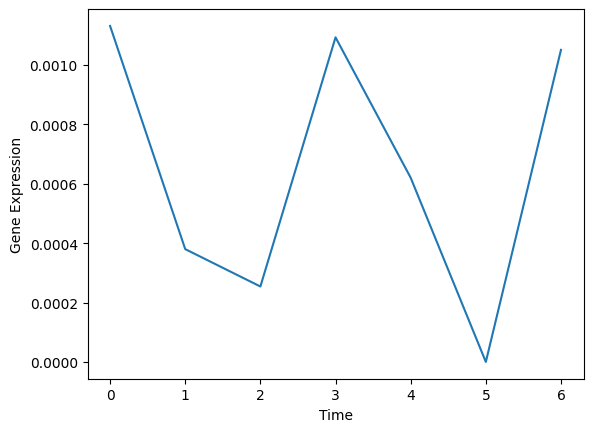

In [14]:
# Look at time series patterns of a selected gene
gene_timeseries = pick_gene(0)
def plot_geneseries(gene):
  length = [x for x in range(len(gene))]
  plt.plot(length, gene)
  plt.xlabel('Time')
  plt.ylabel('Gene Expression')

plot_geneseries(gene_timeseries)

# Model

### KNN Function
Find neighboring genes

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [223]:
# neighbors = NearestNeighbors(n_neighbors=11) # k = 11, k-1 neighbors
neighbors = NearestNeighbors(n_neighbors=9) # k = 9, k-1 neighbors
neighbors.fit(bulks_adata.X.T)
def find_neighbors(g, neighbors_func=neighbors, gene_database=bulks_adata):
  neighbor_arr = neighbors_func.kneighbors([g])
  return neighbor_arr[1][0][1:]

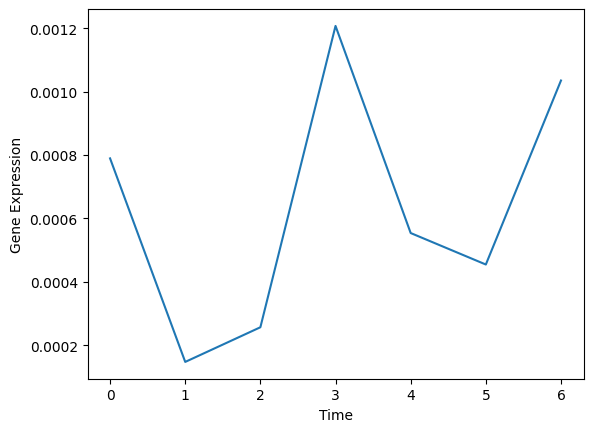

In [224]:
# Check, do the time series looks similar?
gene_0 = pick_gene(0)
gene0_neighbors = find_neighbors(gene_0)
plot_geneseries(pick_gene(gene0_neighbors[1]))

### Data Preprocessing

In [ ]:
# Format input for NN
def format_input(g, gene_database=bulks_adata): # Shape input to our desired format: [g1,...,gt,n1,...,nt,1,2,...,t]
  """
    format_input formats the input for the NN

    :param g: Gene expression values for single gene g
    :param gene_database: Database to pull gene expressions from

    :return: Formatted input, with genes and neighbors as features
  """
  neighbors = find_neighbors(g, gene_database=gene_database) # Get indices of all neighbors of g
  input = np.array(g)

  for n in neighbors:
    neighbor_gene = np.array(pick_gene(n))
    input = np.concatenate((input, neighbor_gene), axis=None) # Concat neighbors with original gene

  return input

gene0 = format_input(pick_gene(0))
print(gene0)

In [ ]:
# Masking mechanism
def mask(time_points, input, mask_value=0, gene_database=bulks_adata): # Time points start form 0. Time points is of type array
  """
    mask is function to mask inputs

    :param time_points: Array. What time points to mask
    :param input: Input array to be masked
    :param gene_database: Database to pull gene expressions from

    :return: Masked array and masked values separately
  """
  new_arr = input.copy()
  max_timepoints = bulks_adata.obs.shape[0]
  masked = []

  first_y = []

  for n in range(len(input)):
    ts_mask = n % max_timepoints
    if ts_mask in time_points: # Mask each time-point for every neighbour
      masked.append(new_arr[n])

      if ts_mask == time_points[0]:
        val = 0
        first_y.append(new_arr[n])
      else:
        val = -1
      new_arr[n] = val # Masked with zero by default

  return new_arr, first_y

test, masked = mask([2, 1], gene0)
print(test, masked)
# 1: 0.00037995086
# 2: 0.00025405543

In [227]:
all_inputs = [] # All inputs, formatted, not scaled
for i in range( int(len(bulks_adata.var)) ):
  # Pick gene and format the input
  gene_i = pick_gene(i)
  formatted_input = format_input(gene_i)

  all_inputs.append(formatted_input)

In [ ]:
print(all_inputs[0])

In [ ]:
X = []
y = []
for i in range(len(all_inputs)):
  gene_i_input = all_inputs[i]

  time_embeddings = [x for x in range(bulks_adata.obs.shape[0])]
  gene_i_input = np.concatenate((gene_i_input, time_embeddings), axis=None) # Concat time embeddings

  masked, value_masked = mask( [randrange( int(len(bulks_adata.obs)) )] , gene_i_input) # Mask arbitrary time-point
  X.append(masked)
  y.append(value_masked[0])

In [228]:
from sklearn.model_selection import train_test_split
X_train_note, X_test_note = train_test_split(all_inputs, train_size=0.8, shuffle=False) # 80/20 Split all inputs

In [ ]:
print(X_train_note[0])

In [229]:
scaler = StandardScaler() # Standard scaler for inputs
X_train_note = scaler.fit_transform(X_train_note)
X_test_note = scaler.transform(X_test_note)

In [230]:
all_data = [] # After scaling, append time embeddings
time_embeddings = [x for x in range(bulks_adata.obs.shape[0])]
for i in range(len(X_train_note)):
  all_data.append( np.append(X_train_note[i], time_embeddings) )

for i in range( len(X_test_note) ):
  all_data.append( np.append(X_test_note[i], time_embeddings) )

In [23]:
len(all_data[0])

70

In [ ]:
X_train = []
X_test = []

y_train = []
y_test = []
time_embeddings = [x for x in range(bulks_adata.obs.shape[0])]

for i in range(len(X_train_note)):
  X_train.append( np.append(X_train_note[i], time_embeddings) )
  alternate = i % len(time_embeddings)

  masked_array, masked_value = mask( [alternate], X_train[i]) # Mask 1 time point. 6 choose 1
  X_train[i] = masked_array
  y_train.append(masked_value[0])

for i in range(len(X_test_note)):
  X_test.append( np.append(X_test_note[i], time_embeddings) )

  alternate = i % len(time_embeddings)

  masked_array, masked_value = mask( [alternate], X_test[i])
  X_test[i] = masked_array
  y_test.append(masked_value[0])

In [231]:
def create_train_test(X_train_note, X_test_note, no_TS_tomask=1, gene_database=bulks_adata):
  """
    create_train_test creates inputs to model for training and testing

    :param no_TS_tomask: integer for how many time points to mask. Default 1
    :param X_train_note: Scaled X_train with no time embeddings
    :param X_test_note: Scaled X_test with no time embeddings

    :return: X_train, X_test, y_train, y_test for model training and testing
  """

  X_train = []
  X_test = []

  y_train = []
  y_test = []
  time_embeddings = [x for x in range(bulks_adata.obs.shape[0])]

  for i in range(len(X_train_note)):
    X_train.append( np.append(X_train_note[i], time_embeddings) )

    random_timepoints = [randrange(0, len(time_embeddings)) for x in range(no_TS_tomask)]

    while len(np.unique(random_timepoints)) != no_TS_tomask:
      random_timepoints = [randrange(0, len(time_embeddings)) for x in range(no_TS_tomask)]

    masked_array, masked_value = mask(random_timepoints, X_train[i])
    X_train[i] = masked_array
    y_train.append(masked_value[0])

  for i in range(len(X_test_note)):
    X_test.append( np.append(X_test_note[i], time_embeddings) )

    random_timepoints = [randrange(0, len(time_embeddings)) for x in range(no_TS_tomask)]

    while len(np.unique(random_timepoints)) != no_TS_tomask:
      random_timepoints = [randrange(0, len(time_embeddings)) for x in range(no_TS_tomask)]

    masked_array, masked_value = mask(random_timepoints, X_test[i])
    X_test[i] = masked_array
    y_test.append(masked_value[0])

  return X_train, X_test, y_train, y_test

In [232]:
X_train = []
X_test = []

y_train = []
y_test = []
for i in range(1, len(time_embeddings)):
  X_train_i, X_test_i, y_train_i, y_test_i = create_train_test(X_train_note, X_test_note, i)
  X_train.extend(X_train_i)
  X_test.extend(X_test_i)
  y_train.extend(y_train_i)
  y_test.extend(y_test_i)

In [63]:
# X_train, X_test, y_train, y_test = create_train_test(X_train_note, X_test_note, 1)

In [69]:
print(X_train[50001])
print(y_train[50001])

[-0.17429415  0.         -0.12021145 -1.         -1.         -0.15544049
 -0.1730106  -0.17530634  0.         -0.13053245 -1.         -1.
 -0.17773682 -0.20924427 -0.17161297  0.         -0.14013679 -1.
 -1.         -0.18933034 -0.21082113 -0.17151804  0.         -0.13358769
 -1.         -1.         -0.18677067 -0.20947103 -0.17001881  0.
 -0.13771717 -1.         -1.         -0.18135868 -0.214075   -0.1723545
  0.         -0.13688036 -1.         -1.         -0.18446611 -0.21580655
 -0.17836925  0.         -0.13636979 -1.         -1.         -0.18713617
 -0.21203534 -0.17617746  0.         -0.1394964  -1.         -1.
 -0.19704047 -0.22194783 -0.17147366  0.         -0.13642879 -1.
 -1.         -0.19186528 -0.21378006  0.          0.          2.
 -1.         -1.          5.          6.        ]
-0.10573448054516292


In [ ]:
# scaler_X = MinMaxScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)

# scaler_y = MinMaxScaler()
# y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(np.array(y_test).reshape(-1, 1)).flatten()

In [233]:
# Adapted form https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel, https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/
class GeneDataset(torch.utils.data.Dataset):
  # Characterizes a dataset for PyTorch
  def __init__(self, X, y):
        # self.genes = genes
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

        # self.X = X.detach().clone()
        # self.y = y.detach().clone()

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        # Generates one sample of data
        gene = self.X[index]
        masked_TS = self.y[index]

        return gene, masked_TS

In [234]:
geneTrainSet = GeneDataset(X_train, y_train)
train_loader = DataLoader(geneTrainSet, shuffle=True, batch_size=8)

In [235]:
geneTestSet = GeneDataset(X_test, y_test)
test_loader = DataLoader(geneTestSet, shuffle=False, batch_size=8)

In [ ]:
# ----------- Deprecated -----------


# Mask arbitrary time-point
# Train X, Y
# X_train = []
# Y_train = []
# for i in range(int(len(bulks_adata.var) * 0.8)): # 80%, 20% split
#   gene_i = pick_gene(i)
#   formatted_input = format_input(gene_i) # Pick gene and format the input
#   masked, value_masked = mask([randrange(len(gene_i))], formatted_input) # Mask arbitrary time-point
#   X_train.append(masked)
#   Y_train.append(value_masked[0])

# # Test X, Y
# X_test = []
# Y_test = []
# for i in range(int(len(bulks_adata.var) * 0.8)+1, len(bulks_adata.var)):
#   gene_i = pick_gene(i)
#   formatted_input = format_input(gene_i)
#   masked, value_masked = mask([randrange(len(gene_i))], formatted_input)
#   X_test.append(masked)
#   Y_test.append(value_masked[0])

In [ ]:
# X_validation = []
# Y_validation = []
# for i in range(int(len(bulks_adata.var) * 0.8)+1, len(bulks_adata.var)):
#   gene_i = pick_gene(i)
#   formatted_input = format_input(gene_i)
#   masked, y = mask([randrange(len(gene_i))], formatted_input)
#   X_test.append(masked)
#   Y_test.append(y[0])

In [ ]:
# Mask all time-points
# Train X, Y
# X_train_t = []
# Y_train_t = []
# for i in range(int(len(bulks_adata.var) * 0.8)): # 80%, 20% split
#   gene_i = pick_gene(i)
#   formatted_input = format_input(gene_i) # Pick gene and format the input

#   for j in range(len(gene_i)): # Mask all time-points
#     masked, y = mask([j], formatted_input)
#     X_train_t.append(masked)
#     Y_train_t.append(y[0])

# # Test X, Y
# X_test_t = []
# Y_test_t = []
# for i in range(int(len(bulks_adata.var) * 0.8)+1, len(bulks_adata.var)):
#   gene_i = pick_gene(i)
#   formatted_input = format_input(gene_i)

#   for j in range(len(gene_i)):
#     masked, y = mask([j], formatted_input)
#     X_test_t.append(masked)
#     Y_test_t.append(y[0])

In [ ]:
# X_train_t = torch.tensor(np.array(X_train), dtype=torch.float32)
# Y_train_t = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)

# X_test_t = torch.tensor(np.array(X_test), dtype=torch.float32)
# Y_test_t = torch.tensor(Y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# X_train = torch.tensor(np.array(X_train_t), dtype=torch.float32)
# Y_train = torch.tensor(Y_train_t, dtype=torch.float32).reshape(-1, 1)

# X_test = torch.tensor(np.array(X_test_t), dtype=torch.float32)
# Y_test = torch.tensor(Y_test_t, dtype=torch.float32).reshape(-1, 1)

### Regression DNN
[PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

In [236]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork(70, 1) # 7
model.load_state_dict(torch.load("/content/model.pth"))

In [237]:
model = NeuralNetwork(70, 1)
loss_fn = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00001)

optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [238]:
def train_model(model, loader, optimizer, loss_fn, epochs):
    model.train()
    epoch_vals = []
    loss_vals = []

    for epoch in range(epochs):
      epoch_vals.append(epoch)
      last_loss = 0

      for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.unsqueeze(1)
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        last_loss = loss.item()

      scheduler.step()

      loss_vals.append(last_loss)
      print(f'Epoch {epoch}: Loss = {last_loss}')

train_model(model, train_loader, optimizer, loss_fn, epochs=4)

Epoch 0: Loss = 0.006133284419775009
Epoch 1: Loss = 0.004688190296292305
Epoch 2: Loss = 0.0031232298351824284
Epoch 3: Loss = 0.00045858602970838547


In [239]:
model.eval()

y_pred = model(torch.tensor(X_test, dtype=torch.float32))
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

loss = loss_fn(y_pred, y_test_tensor)

print(f'Test Loss: {loss.item()}')

Test Loss: 9.226900100708008


In [80]:
torch.save(model.state_dict(), "model_allTS.pth")

In [240]:
# RMSE
rmse = torch.sqrt(loss)
print(f'Root Mean Squared Error: {rmse.item()}')

# MAE
mae = torch.mean(torch.abs(y_pred - y_test_tensor))
print(f'Mean Absolute Error: {mae.item()}')

Root Mean Squared Error: 3.037581205368042
Mean Absolute Error: 0.14192605018615723


#### Measuring Performance
For each gene, measure avg accuracy, correlation, MAE, MSE

In [241]:
def MAE(pred, y):
  return abs(pred-y)

def MSE(pred, y):
  return (pred-y)**2

def RMSE(pred, y):
  return torch.sqrt(MSE(pred, y))

In [253]:
# Given a gene, for each masked time point, measure metric on predicted value
def metric_for_timepoints(gene_no, metric_func, model=model, database=all_data, plot=False, printB=False):
  """
    metric_for_timepoints calculate performance metric for prediction of each hidden time point for single gene gene_no

    :param gene_no: Gene to pick
    :param metric_func: Metric function to measure performance (MAE is preferred)

    :return: Value of metric for each hidden time point for gene_no, also prints lowest value
  """
  # gene = pick_gene(gene_no)
  # formatted_input = format_input(gene)
  model.eval()
  gene = database[gene_no]
  max_TS = int(gene[-1])+1

  metric_values = []

  with torch.no_grad():
    for i in range(max_TS):
      masked, y = mask([i], gene)
      masked, y = torch.tensor(masked, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)

      prediction = model(masked) # Get predicted value for time point i
      metric_measure = metric_func(prediction, y)[0].item() # Measure error using metric_func
      metric_values.append(metric_measure) # Append value of error

      if printB: print(f'{metric_func.__name__} for time point {i}: {metric_measure}') # Print error value for each time point

  metric_values = np.array(metric_values)

  if printB:
    print(f'Average {metric_func.__name__}: {metric_values.sum()/len(metric_values)}') # Print average value for all time points
    print(f'Lowest time point: {metric_values.argmin()}')

  if plot:
    length = [x for x in range(len(gene))]
    metric_values = [x.item() for x in metric_values]
    plt.plot(length, metric_values)
    plt.xlabel('Time')
    plt.ylabel('Measurement')

  return metric_values # Error values with metric_func for all time points for gene_no

In [254]:
vals = metric_for_timepoints(24002, MAE, model, printB=True)

MAE for time point 0: 0.011718124151229858
MAE for time point 1: 0.037344448268413544
MAE for time point 2: 0.028001710772514343
MAE for time point 3: 0.04954451322555542
MAE for time point 4: 0.016635149717330933
MAE for time point 5: 0.007686525583267212
MAE for time point 6: 0.018357321619987488
Average MAE: 0.024183970476899828
Lowest time point: 5


In [255]:
# Average metric of specific time point, for genes form 0 to test_timepoints. Prints avg for all genes at specified time point
def avg_metric(metric_func, time_points=len(bulks_adata.obs), number_genes=len(bulks_adata.var), printB=False):
  """
    avg_metric calculate performance metric for prediction of each hidden time point for every gene in database

    :param time_points: How many time points to measure
    :param metric_func: Metric function to measure performance (MAE is preferred)

    :return: Average value of metric for each hidden time point for all genes, also prints lowest value
  """
  avg_val = np.zeros(time_points)

  for i in range(number_genes):
    vals = metric_for_timepoints(i, metric_func, model)
    avg_val += vals

  avg_val = avg_val/number_genes
  avg_val_minmax = (avg_val - avg_val.min()) / (avg_val.max() - avg_val.min())

  avg_allTS = 0

  for t in range(time_points):
    avg_allTS += avg_val_minmax[t]/time_points
    if printB: print(f'Average {metric_func.__name__} value for all genes at time point {t}: {avg_val_minmax[t]}')

  print()
  print(f'Average {metric_func.__name__} value for all genes: {avg_allTS}')
  print(f'Lowest time point: {avg_val_minmax.argmin()}')

  return avg_val

In [256]:
tavg_MAE = avg_metric(MAE, printB=True)

Average MAE value for all genes at time point 0: 1.0
Average MAE value for all genes at time point 1: 0.6381359998325412
Average MAE value for all genes at time point 2: 0.2699889886863547
Average MAE value for all genes at time point 3: 0.3624169926702696
Average MAE value for all genes at time point 4: 0.0
Average MAE value for all genes at time point 5: 0.4450393414247858
Average MAE value for all genes at time point 6: 0.8994574501556178

Average MAE value for all genes: 0.5164341103956527
Lowest time point: 4


In [ ]:
def generate_combintations(n, time_points=time_embeddings):
  """
    generate_combintations generates combinations for masking of time points of length n.
    First element is masked and to be predicted, rest are masked.
    Function generates special kind of permutation where only order of first element matters.

    :param time_points: Max number of time points
    :param n: Length of combination (number of time points to mask)

    :return: List of combinations
  """
  combinations = []
  to_skip = int(math.factorial(n-1))-1 # Want only permutations where first number is different, skip the rest
  skipped = to_skip

  # time_array = [x for x in range(time_points)]

  for comb in itertools.combinations(time_points, n): # Generate combinations of length n
    to_avg = [] # Group together permutations that will be averaged in the end

    for permutation in list(itertools.permutations(comb)): # Generate permutations of those combinations
      if skipped > 0: # Dont want all permutations
        skipped -= 1
        continue

      to_avg.append(list(permutation))


      skipped = to_skip

    combinations.append(to_avg)

    # e.g. combinations[0] has lists of size n. Caluclate MAE for predictions of all of them, take average.

  return combinations

generate_combintations(3)

In [219]:
def metric_combinationTS(gene_no, metric_func, n, database=all_data, model=model, time_points=time_embeddings, printB=False):
  """
    metric_combinationTS calculate performance metric for prediction of combinations hidden time points for single gene in database

    :param time_points: How many time points to measure
    :param metric_func: Metric function to measure performance (MAE is preferred)

    :return: Average value of metric for each hidden time point for all genes, also prints lowest value
  """

  model.eval()
  gene = database[gene_no]
  max_TS = int(gene[-1])+1

  combinations = generate_combintations(n)

  metric_values = []
  # all_avg_vals = []

  with torch.no_grad():
    for comb in combinations: # Sequence of combinations to average
      combintation_sum = 0 # Sum absolute error of all combinations, then divide by n

      for sequence in comb: # Calculate MAE for each sequence, average them
        # print(sequence)
        masked, y = mask(sequence, gene)
        # print(masked)
        # print(y)

        masked, y = torch.tensor(masked, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)

        prediction = model(masked) # Get predicted value for time points
        # print(prediction)
        metric_measure = metric_func(prediction, y)[0].item() # Measure error using metric_func
        combintation_sum += metric_measure

      avg_combination = combintation_sum/n
      metric_values.append(avg_combination) # Append value of error

      if printB: print(f'{metric_func.__name__} for time point(s) {comb[0]}: {avg_combination}') # Print error value for each time point(s)

  metric_values = np.array(metric_values)

  if printB:
    print(f'Average {metric_func.__name__}: {metric_values.sum()/len(metric_values)}') # Print average value for all time points
    print(f'Lowest time point(s): {combinations[metric_values.argmin()][0] }')

  return metric_values

In [222]:
ar_24002 = metric_combinationTS(24002, MAE, 2, printB=True)

MAE for time point(s) [0, 1]: 0.04603015258908272
MAE for time point(s) [0, 2]: 0.06253673508763313
MAE for time point(s) [0, 3]: 0.019330568611621857
MAE for time point(s) [0, 4]: 0.012331448495388031
MAE for time point(s) [0, 5]: 0.05654804781079292
MAE for time point(s) [0, 6]: 0.01321689784526825
MAE for time point(s) [1, 2]: 0.02391708269715309
MAE for time point(s) [1, 3]: 0.024944137781858444
MAE for time point(s) [1, 4]: 0.06051851436495781
MAE for time point(s) [1, 5]: 0.04886321723461151
MAE for time point(s) [1, 6]: 0.03982365503907204
MAE for time point(s) [2, 3]: 0.04909629374742508
MAE for time point(s) [2, 4]: 0.07281072065234184
MAE for time point(s) [2, 5]: 0.12961407750844955
MAE for time point(s) [2, 6]: 0.06462455168366432
MAE for time point(s) [3, 4]: 0.008045390248298645
MAE for time point(s) [3, 5]: 0.03840326890349388
MAE for time point(s) [3, 6]: 0.04005608707666397
MAE for time point(s) [4, 5]: 0.06493601202964783
MAE for time point(s) [4, 6]: 0.05130640417337

In [ ]:
def avg_metric_combinationTS(metric):
  """
    avg_metric_combinationTS calculate average performance metric for prediction of combinations hidden time points for every gene in database

    :param time_points: How many time points to measure
    :param metric_func: Metric function to measure performance (MAE is preferred)

    :return: Average value of metric for each hidden time point for all genes, also prints lowest value
  """

  return

In [49]:
# Calculate correlation for predicted and truth value for all genes, at a specific time point
def correlation_timepoint(time_point, database=all_data, model=model, printB=False, plot=False):
  if time_point >= len(bulks_adata.obs):
    print(f'Time point {time_point} out of range')
    return None

  model.eval()

  y_truth = np.zeros(len(bulks_adata.var))
  y_pred = np.zeros(len(bulks_adata.var))

  with torch.no_grad():
    for i in range(len(bulks_adata.var)):
      # gene_i = pick_gene(i)
      # formatted_input = format_input(gene_i)
      formatted_input = database[i]
      # print(formatted_input)

      masked, y = mask([time_point], formatted_input)
      # print(len(masked))
      masked, y = torch.tensor(masked, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)

      # print(masked)

      prediction = model(masked) # Get predicted value for masked time_point

      y_truth[i] = y.item()
      y_pred[i] = prediction.item()

  SSR = np.square((y_truth-y_pred)).sum()
  SST = np.square((y_truth-y_truth.mean())).sum()
  R_square = 1 - SSR/SST

  r = scipy.stats.pearsonr(y_truth, y_pred)
  r_square = r[0]**2

  if printB:
    print(f'Pearson Correlation Coefficient (R) for time point {time_point}: {r[0]}')
    print(f'Coefficient of Determination (R^2) for {time_point}: {r_square}\n')
    # print(f'R^2 manual {R_square}')

  if plot:
    plt.title(f"Scatter plot of true and predicted values for all genes at time {time_point}")
    plt.scatter(y_truth, y_pred)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.show()
  return r[0]

In [50]:
# Calculate average correlation for predicted and truth value for all genes, for all time points
def correlation_avg(printB=False):
  avg_r = 0
  avg_r_square = 0

  r_values = []
  for i in range(len(bulks_adata.obs)):
    r_i = correlation_timepoint(i)
    r_values.append(r_i)

    avg_r += r_i
    avg_r_square += r_i**2

  avg_r = avg_r/len(bulks_adata.obs)
  avg_r_square = avg_r_square/len(bulks_adata.obs)

  if printB:
    for i in range(len(bulks_adata.obs)):
      print(f'Pearson Correlation Coefficient (R) for time point {i}: {r_values[i]}')
      print(f'Coefficient of Determination (R^2) for  {i}: {r_values[i] ** 2}\n')

    print(f'Average Pearson Correlation Coefficient (R): {avg_r}')
    print(f'Average Coefficient of Determination (R^2): {avg_r_square}')

  return avg_r, avg_r_square

In [51]:
avg_r, avg_r_square = correlation_avg(printB=True)

Pearson Correlation Coefficient (R) for time point 0: 0.8847368732980078
Coefficient of Determination (R^2) for  0: 0.782759334973135

Pearson Correlation Coefficient (R) for time point 1: 0.880714236355382
Coefficient of Determination (R^2) for  1: 0.7756575661190438

Pearson Correlation Coefficient (R) for time point 2: 0.7695216424435524
Coefficient of Determination (R^2) for  2: 0.5921635581890224

Pearson Correlation Coefficient (R) for time point 3: 0.5912046983617678
Coefficient of Determination (R^2) for  3: 0.34952299536502884

Pearson Correlation Coefficient (R) for time point 4: 0.6143665839608211
Coefficient of Determination (R^2) for  4: 0.37744629948768865

Pearson Correlation Coefficient (R) for time point 5: 0.2787501071087457
Coefficient of Determination (R^2) for  5: 0.0777016222131372

Pearson Correlation Coefficient (R) for time point 6: 0.5356225561401493
Coefficient of Determination (R^2) for  6: 0.2868915226461074

Average Pearson Correlation Coefficient (R): 0.6